In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys

import os, sys

%matplotlib inline

In [2]:
from box import Box
import glob

In [3]:
TOP = os.getcwd().replace("notebooks/tt", "")
D1 = TOP + 'data/'
figures_dir = TOP + 'manuscript/figures/'

### DATA

In [4]:
CHM1 = pd.read_csv(D1 + 'S7-chem.tsv', sep='\t', low_memory=False)
CHM1 = CHM1.replace(['-'], np.nan)
CHM1.isnull().values.any()
CHM1 = CHM1.dropna()
CHM1
CHM1_nm = CHM1[['DTXSID', 'PREFERRED_NAME']].set_index('DTXSID')
X = CHM1 = CHM1.drop(['PREFERRED_NAME'], axis=1).set_index('DTXSID')

CHM11 = Box()
for i in set([i[0] for i in X.columns.str.split('_') ]):
    CHM11[i] =  X[X.columns[X.columns.str.match(i)]]
CHM11['all'] = X

In [5]:
BIO1 = pd.read_csv(D1+'S2-bio.tsv', sep='\t') 
BIO1 = BIO1.rename(columns = {'dsstox_substance_id':'DTXSID'})

BIO1 = BIO1.drop(['chnm', 'casn'], axis = 1).set_index('DTXSID')
BIO11 = Box()
for i in set([i[0] for i in BIO1.columns.str.split('_')]):
    BIO11[i]=BIO1[BIO1.columns[BIO1.columns.str.match(i)]]
BIO11['all']=BIO1

In [6]:
TOX1 = pd.read_csv(D1+'S1-tox.tsv', sep='\t')

TOX1 = TOX1.rename(columns = {'dsstox_substance_id':'DTXSID'})
TOX1 = TOX1.drop(['preferred_name'], axis=1).set_index('DTXSID')
#set([i[0] for i in TOX1.columns.str.split('_')])
TOX11 = Box()
for i in set([i[0] for i in TOX1.columns.str.split('_')]):
    TOX11[i] = TOX1[TOX1.columns[TOX1.columns.str.match(i)]]
TOX11['all'] = TOX1

In [7]:
DATA = Box(chm=CHM11,bio=BIO11,tox=TOX11)
DATA['bc'] = Box()

for c,b in [(i,j) for i in CHM11.keys() for j in BIO11.keys()]:
    print(b,c)
    DATA['bc']['{}_{}'.format(b,c)] = CHM11[c].merge(BIO11[b],left_index=True,right_index=True)

gene toxp
assay toxp
all toxp
gene mrgn
assay mrgn
all mrgn
gene tptr
assay tptr
all tptr
gene all
assay all
all all


In [8]:
[e for e in TOX1.columns if 'liver' in e]

['chr_liver',
 'dev_liver',
 'dev_premature_delivery',
 'dnt_liver',
 'mgr_liver',
 'neu_liver',
 'oth_liver',
 'rep_liver',
 'sac_liver',
 'sub_liver']

In [9]:
effects = ['chr_liver', 'dev_liver']

### DEF getDATA

In [10]:
def getData(b,dt='chm',st='all',Data=DATA):
    """
    Return an input and output dataframe for analysis
    
    b = toxicity class
    dt= input data type (chm or bio)
    st= inpute subdata type ()
    """
    
    Y = Data.tox.all[b].dropna()
    INT=Data[dt][st].index.intersection(Y.index)
    if len(INT)>0:
        Yf= Y.copy()[INT]
        Yf[Yf>0]=1
        Yb = Yf.copy()
        Yb = Yb.astype(np.int32)
        X  = Data[dt][st].loc[INT].fillna(0)
    else:
        pass
    
    return X,Yb

In [11]:
#getData('chr_liver',dt='chm',st='mrgn')


In [12]:
mydict = {}
for e in effects:
    data = getData(e,dt='chm',st='mrgn')
    mydict[e] = data

In [13]:
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings

## No balancing

In [14]:

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, precision_score
from collections import Counter

### Model Validation Using chm descriptors unbalanced

In [15]:
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
#from sklearn.tree import DecisionTreeClassifier

from genra.rax.skl.cls import *
from sklearn.model_selection import StratifiedKFold


In [16]:
def model_cv(d,  label = None):
    Res = []
    Est = [('Random Forest', RandomForestClassifier(random_state=42)),
          ('NB', BernoulliNB()),
          ('LR', LogisticRegression(max_iter=1000)),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('SVC', SVC(gamma='auto',probability=True)),
          ('KNN',KNeighborsClassifier()),
          ('ANN1',MLPClassifier(solver='sgd')),
          ('GenRA', GenRAPredClass(n_neighbors=10,metric='jaccard'))]
    
    X, Y = d
    for (LR,Clf) in Est:
    #print('\n>>',LR)
    #start_time = datetime.now()
        score = cross_validate(Clf, X, Y,
                           cv=StratifiedKFold(n_splits = 5),
                           scoring= {'accuracy': make_scorer(accuracy_score),
                                     'f1': make_scorer(f1_score),
                                     'sensitivity': make_scorer(recall_score),
                                     'specificity': make_scorer(recall_score,pos_label=0),
                                    'precision': make_scorer(precision_score)},
                           n_jobs=-1, verbose=1)
    #elapsed_time = datetime.now() - start_time
        SC = pd.DataFrame(score)
        SC.insert(0,'LR',LR)
        Res.append(SC)
    return Res

In [17]:
def plugin(d, label=None):
    summary = {}
    X, Y = d
    summary['label'] = label
    summary['score'] = model_cv(d)
    
    return summary

In [18]:
chm_summaries = []
for k in list(mydict.keys()):
    try:
        chm_summaries.append(plugin(mydict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [19]:
myperm2 = {}
myperm = {}
for i in range(len(chm_summaries)):
    k = chm_summaries[i]['label']
    Perf = pd.concat(chm_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    myperm[k] = Perf_agg
    myperm2[k] = Perf       

In [20]:
Perf_mgrn = pd.concat(myperm)    
Perf_mgrn_raw = pd.concat(myperm2)   

In [21]:
Perf_mgrn

Perf_mgrn_raw.to_csv(D1 + '/ML_unbal_mgrn_all_140823.csv' )
Perf_mgrn.to_csv(D1 + '/ML_unbal_mgrn_summary_140823.csv' )

## Model Validation Using Bio (gene hitc) Descriptors

In [22]:
bio_dict = {}
for e in effects:
    data = getData(e,dt='bio',st='gene')
    bio_dict[e] = data

In [23]:
bio_summaries = []
for k in list(bio_dict.keys()):
    try:
        bio_summaries.append(plugin(bio_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [24]:
bio_perm2 = {}
bio_perm = {}
for i in range(len(bio_summaries)):
    k = bio_summaries[i]['label']
    Perf = pd.concat(bio_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    bio_perm[k] = Perf_agg
    bio_perm2[k] = Perf

In [25]:
Perf_bio = pd.concat(bio_perm)  
Perf_bio_raw = pd.concat(bio_perm2)  

In [26]:
Perf_bio_raw.to_csv(D1 + '/ML_unbal_bio_all_140823.csv' )
Perf_bio.to_csv(D1 + '/ML_unbal_bio_summary_140823.csv' )        
        

## Model Validation Using Hybrid (chm(mrgn) + bio(hitc)) Descriptors

In [27]:
hybrid_dict = {}
for e in effects:
    data = getData(e,dt='bc',st='gene_mrgn')
    hybrid_dict[e] = data

In [28]:
hybrid_summaries = []
for k in list(hybrid_dict.keys()):
    try:
        hybrid_summaries.append(plugin(hybrid_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [29]:
myperm2 = {}
myperm = {}
for i in range(len(hybrid_summaries)):
    k = hybrid_summaries[i]['label']
    Perf = pd.concat(hybrid_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    myperm[k] = Perf_agg
    myperm2[k] = Perf

In [30]:
Perf_hybrid = pd.concat(myperm)  
Perf_hybrid_raw = pd.concat(myperm2) 

In [31]:
Perf_hybrid_raw.to_csv(D1 + '/ML_unbal_hybrid_all_140823.csv' )
Perf_hybrid.to_csv(D1 + '/ML_unbal_hybrid_summary_140823.csv' )  

## Model Validation Using All Chm (mrgn + tptr + toxp) Descriptors     

In [32]:
ca_dict = {}
for e in effects:
    data = getData(e,dt='chm',st='all')
    ca_dict[e] = data




In [33]:
ca_summaries = []
for k in list(ca_dict.keys()):
    try:
        ca_summaries.append(plugin(ca_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [34]:
ca_perm2 = {}
ca_perm = {}
for i in range(len(ca_summaries)):
    k = ca_summaries[i]['label']
    Perf = pd.concat(ca_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    ca_perm[k] = Perf_agg
    ca_perm2[k] = Perf

In [35]:
Perf_ca = pd.concat(ca_perm)  
Perf_ca_raw = pd.concat(ca_perm2)  

In [36]:
Perf_ca_raw.to_csv(D1 + '/ML_unbal_ca_all_140823.csv' )
Perf_ca.to_csv(D1 + '/ML_unbal_ca_summary_140823.csv' )  

## Model Validation Using All Chm + bio (mrgn + tptr + toxp + bio) Descriptors

In [37]:
bc_dict = {}
for e in effects:
    data = getData(e,dt='bc',st='gene_all')
    bc_dict[e] = data

In [38]:
bc_summaries = []
for k in list(bc_dict.keys()):
    try:
        bc_summaries.append(plugin(bc_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [39]:
bc_perm2 = {}
bc_perm = {}
for i in range(len(bc_summaries)):
    k = bc_summaries[i]['label']
    Perf = pd.concat(bc_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    bc_perm[k] = Perf_agg
    bc_perm2[k] = Perf

In [40]:
Perf_bc = pd.concat(bc_perm)  
Perf_bc_raw = pd.concat(bc_perm2)  

In [41]:
Perf_bc_raw.to_csv(D1 + '/ML_unbal_cba_all_140823.csv' )
Perf_bc.to_csv(D1 + '/ML_unbal_cba_all_summary_140823.csv' )    

In [42]:
def pref_files(df, dt, st, bl):
    df = df.reset_index()
    df.columns = ['tox', 'classifier', 'mean_f1', 'std_f1', 'mean_sensitivity', 'std_sensitivity', 'mean_specificity', 'std_specificity', 'mean_accuracy', 'std_accuracy', 'mean_precision', 'std_precision']
    #df = df.drop([0,1])
    df['dt'] = dt 
    df['balance'] = bl
    df['sampling'] = st
    #df = pd.merge(df, df_counts, on = 'tox', how = 'left')
    return df

In [43]:
#pref_files(Perf_mgrn, 'mgrn')

In [44]:
mylst = ['mrgn', 'gene', 'cb', 'ca', 'cba']

In [45]:
mylst2 = list(zip(mylst, [Perf_mgrn, 
Perf_bio, 
Perf_hybrid,
Perf_ca, 
Perf_bc ], ))

In [46]:
mylst3 = []
for e in mylst2:
    a,b = e
    mylst3.append(pref_files(b,a, st = 'unbalanced', bl = 'unbalanced'))

In [47]:
final_df = pd.concat(mylst3)

In [48]:
final_df

,tox,classifier,mean_f1,std_f1,mean_sensitivity,std_sensitivity,mean_specificity,std_specificity,mean_accuracy,std_accuracy,mean_precision,std_precision,dt,balance,sampling
0,chr_liver,ANN1,0.782,0.009,0.987,0.012,0.008,0.018,0.643,0.013,0.647,0.009,mrgn,unbalanced,unbalanced
1,chr_liver,GenRA,0.751,0.041,0.804,0.133,0.390,0.235,0.659,0.035,0.717,0.050,mrgn,unbalanced,unbalanced
2,chr_liver,Gradient Boosting,0.748,0.021,0.826,0.059,0.298,0.117,0.640,0.025,0.686,0.030,mrgn,unbalanced,unbalanced
3,chr_liver,KNN,0.461,0.172,0.402,0.200,0.516,0.175,0.442,0.083,0.586,0.096,mrgn,unbalanced,unbalanced
4,chr_liver,LR,0.746,0.053,0.796,0.119,0.391,0.128,0.654,0.049,0.708,0.032,mrgn,unbalanced,unbalanced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,dev_liver,KNN,0.076,0.105,0.044,0.061,0.991,0.012,0.836,0.009,0.300,0.447,cba,unbalanced,unbalanced
12,dev_liver,LR,0.106,0.148,0.069,0.101,0.977,0.032,0.828,0.034,0.300,0.447,cba,unbalanced,unbalanced
13,dev_liver,NB,0.000,0.000,0.000,0.000,0.991,0.020,0.828,0.014,0.000,0.000,cba,unbalanced,unbalanced
14,dev_liver,Random Forest,0.000,0.000,0.000,0.000,0.991,0.013,0.828,0.018,0.000,0.000,cba,unbalanced,unbalanced


In [50]:
writer = pd.ExcelWriter(D1+'liver_unbalanced_all_140823.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_df.to_excel(writer, sheet_name = 'all')

writer.save()

In [4]:
final_df = pd.read_excel(D1+'liver_unbalanced_all_140823.xlsx')

In [15]:
final_df

,Unnamed: 0,tox,classifier,mean_f1,std_f1,mean_sensitivity,std_sensitivity,mean_specificity,std_specificity,mean_accuracy,std_accuracy,mean_precision,std_precision,dt,balance,sampling
0,0,chr_liver,ANN1,0.782,0.009,0.987,0.012,0.008,0.018,0.643,0.013,0.647,0.009,mrgn,unbalanced,unbalanced
1,1,chr_liver,GenRA,0.751,0.041,0.804,0.133,0.390,0.235,0.659,0.035,0.717,0.050,mrgn,unbalanced,unbalanced
2,2,chr_liver,Gradient Boosting,0.748,0.021,0.826,0.059,0.298,0.117,0.640,0.025,0.686,0.030,mrgn,unbalanced,unbalanced
3,3,chr_liver,KNN,0.461,0.172,0.402,0.200,0.516,0.175,0.442,0.083,0.586,0.096,mrgn,unbalanced,unbalanced
4,4,chr_liver,LR,0.746,0.053,0.796,0.119,0.391,0.128,0.654,0.049,0.708,0.032,mrgn,unbalanced,unbalanced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,11,dev_liver,KNN,0.076,0.105,0.044,0.061,0.991,0.012,0.836,0.009,0.300,0.447,cba,unbalanced,unbalanced
76,12,dev_liver,LR,0.106,0.148,0.069,0.101,0.977,0.032,0.828,0.034,0.300,0.447,cba,unbalanced,unbalanced
77,13,dev_liver,NB,0.000,0.000,0.000,0.000,0.991,0.020,0.828,0.014,0.000,0.000,cba,unbalanced,unbalanced
78,14,dev_liver,Random Forest,0.000,0.000,0.000,0.000,0.991,0.013,0.828,0.018,0.000,0.000,cba,unbalanced,unbalanced


In [22]:
final_melt = final_df.melt(id_vars = ['tox', 'classifier', 'dt',], value_vars = ['mean_f1', 'mean_sensitivity', 'mean_specificity', 'mean_precision'], var_name = 'perf')

In [23]:
final_melt

,tox,classifier,dt,perf,value
0,chr_liver,ANN1,mrgn,mean_f1,0.782
1,chr_liver,GenRA,mrgn,mean_f1,0.751
2,chr_liver,Gradient Boosting,mrgn,mean_f1,0.748
3,chr_liver,KNN,mrgn,mean_f1,0.461
4,chr_liver,LR,mrgn,mean_f1,0.746
...,...,...,...,...,...
315,dev_liver,KNN,cba,mean_precision,0.300
316,dev_liver,LR,cba,mean_precision,0.300
317,dev_liver,NB,cba,mean_precision,0.000
318,dev_liver,Random Forest,cba,mean_precision,0.000


In [24]:
toxics = ['chr_liver']*8 + ['dev_liver']*8

In [25]:
clas = final_melt.classifier.unique().tolist() + final_melt.classifier.unique().tolist()

In [26]:
import seaborn as sns

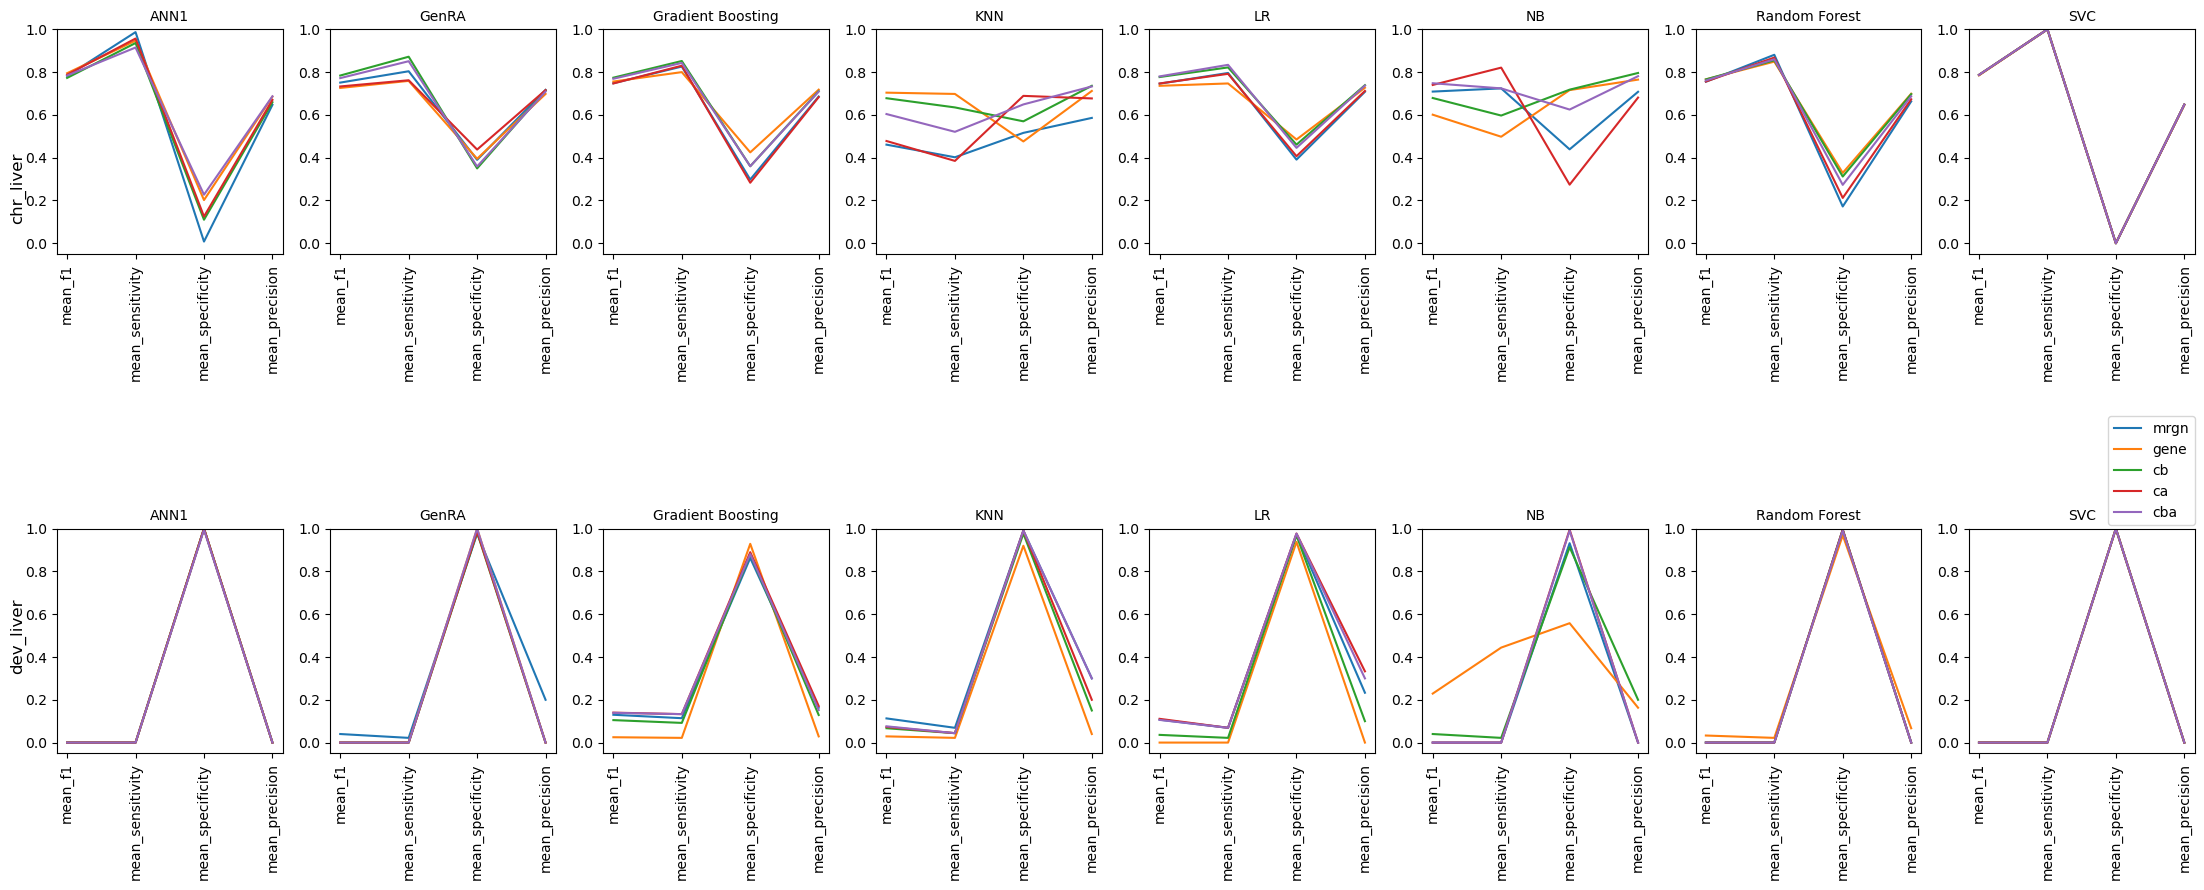

In [27]:
f1 = plt.figure(figsize = (22,9))

for c,e, num in zip(clas, toxics, range(1,18)):
    df0 = final_melt
    df1 = df0[(df0['tox'] == e) & (df0['classifier'] ==c)]
    ax1 = f1.add_subplot(2,8,num)
    g = sns.lineplot(x = 'perf', y = 'value', hue = 'dt', data = df1)
    for xlab in ax1.get_xticklabels():xlab.set_rotation(90)
    ax1.set_title(c, fontsize = 10)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_ylim(-0.05,1)
    ax1.get_legend().remove()
    handles, labels = ax1.get_legend_handles_labels()
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1, 1.5), loc=1, borderaxespad=0.)
plt.subplots_adjust(bottom=0.25, right=0.75, top=0.9)
f1.text(0,0.75, "chr_liver", fontsize = 12, rotation = 'vertical')
f1.text(0,0.25, "dev_liver", fontsize = 12,rotation = 'vertical')
plt.tight_layout()

In [33]:
final_melt[final_melt['perf'] == 'mean_f1'].groupby(['tox', 'classifier']).mean()

value
tox       classifier               
chr_liver ANN1               0.7844
          GenRA              0.7532
          Gradient Boosting  0.7588
          KNN                0.5850
          LR                 0.7572
          NB                 0.6954
          Random Forest      0.7608
          SVC                0.7866
dev_liver ANN1               0.0000
          GenRA              0.0080
          Gradient Boosting  0.1078
          KNN                0.0716
          LR                 0.0720
          NB                 0.0538
          Random Forest      0.0066
          SVC                0.0000

In [31]:
final_melt

,tox,classifier,dt,perf,value
0,chr_liver,ANN1,mrgn,mean_f1,0.782
1,chr_liver,GenRA,mrgn,mean_f1,0.751
2,chr_liver,Gradient Boosting,mrgn,mean_f1,0.748
3,chr_liver,KNN,mrgn,mean_f1,0.461
4,chr_liver,LR,mrgn,mean_f1,0.746
...,...,...,...,...,...
315,dev_liver,KNN,cba,mean_precision,0.300
316,dev_liver,LR,cba,mean_precision,0.300
317,dev_liver,NB,cba,mean_precision,0.000
318,dev_liver,Random Forest,cba,mean_precision,0.000
